# PHAS2441 Session 8:  More Ordinary Differential Equations

In this session we'll expand on the Runge Kutta approach we met in session 7, and apply it to more situations you're likely to come across in Physics.



## Simultaneous first-order differential equations

Often we're going to want to solve systems which involve differential equations with more than one variable. For example, we could have a system involving $x(t)$ and $y(t)$:

$$ \frac{dx}{dt}  = xy - x, \\ \frac{dy}{dt}  = y - xy + \sin^2(\omega t)$$


We can generalise this type of problem using vector notation:

$$ \frac{d \mathbf{r}}{dt} = {\mathbf f}({\mathbf r},t),$$

where $\mathbf r$ is a general vector ${\mathbf r} = (x, y, \ldots)$, and ${\mathbf f}({\mathbf r},t)$ is a corresponding vector of _functions_ $f_x({\mathbf r},t), f_y({\mathbf r},t)), \ldots$. Note that this is just a very concise way of saying that we have a simultaneous system of equations.

If we wanted to solve a system like this analytically, things could get complicated very quickly. This is where the real strength of numerical approaches comes in, as it's relatively simple to extend the approaches we've already used to a multi-variable system.

To see this, let's do a Taylor expansion of our vector ${\mathbf r}$:

$$ {\mathbf r}(t + h) = {\mathbf r}(t) + h \frac{d {\mathbf r}}{dt} + \mathcal{O}(h^2) \\
\qquad = {\mathbf r}(t) + h {\mathbf f}({\mathbf r},t) + \mathcal{O}(h^2) $$

which we can see is just an extension of what we had for the Euler method. The Runge-Kutta method can also be generalised in the same way.

### Coding this example

To start, we'll import the modules we'll need - in this case just the standard numpy and matplotlib:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Just as we did in the previous session, we're going to write a python function to represent our equation

$$ \frac{d \mathbf{r}}{dt} = {\mathbf f}({\mathbf r},t),$$

Whereas before our function depended on $x(t)$ and $t$, now it depends on a vector ${\mathbf r}(t)$ and $t$:

In [3]:
def f(r,t):
    '''Definition of the vector function to be solved
    Inputs are r (a vector) and t'''
    x = r[0] # first element of r represents x, etc
    y = r[1] # second element of r represents y, etc
    fx = x*y - x
    fy = y - x*y + np.sin(t)**2
    return np.array([fx,fy],float) # convert fx and fy to an array form and ensure it's a float

Next we need to define our basic variables, the time interval, and the step. We'll take as our initial conditions
$$ x(t=0) = 1 \\
y(t=0) = 1 $$

In [4]:
tstart = 0.0 # start time
tend = 10.0  # end time
N = 1000     # number of points for Runge-Kutta
h = (tend - tstart)/N  # step length

# define an array of timepoints
tpoints = np.arange(tstart, tend, h)

# define the initial conditions in an array:
# at t = 0, x = y = 1
r = np.array([1.0,1.0])

Now we'll rewrite our 4th-order Runge Kutta function. To extend this to two dimensions, we'll use arrays for both the $x$ and $y$ components - the Runge Kutta equations themselves are identical though, just with $x$ replaced by ${\mathbf r}$. If we wanted to extend this to higher dimensions (e.g. if we had three, or more, simultaneous equations to solve for), then this is easy to do.

In [5]:
def RungeKutta2d(r,tpoints):
    '''Fourth-order Runge-Kutta rewritten for two simultaneous equations
    Inputs: r: 2-component array , first component is x, second y
            tpoints: array of time values.
    Outputs: [xpoints, ypoints]: solutions for x(t) and y(t), numpy arrays of same length as tpoints'''
    xpoints = [] # initialise empty arrays
    ypoints = []
    for t in tpoints:
        xpoints.append(r[0])
        ypoints.append(r[1])
        # The following is the same as before, with x->r
        k1 = h*f(r,t) 
        k2 = h*f(r+0.5*k1, t+0.5*h)
        k3 = h*f(r+0.5*k2, t+0.5*h)
        k4 = h*f(r+k3, t+h)
        r = r + (k1 + 2*k2 + 2*k3 + k4)/6
    return np.array([xpoints, ypoints]) # convert output to numpy array with 2 rows and N columns
   

Now we can call the Runge Kutta function to solve the system. Let's also check what shape the resulting array "rsol" has.

In [6]:
rsol = RungeKutta2d(r,tpoints) # this will be an array of the x and y solutions

print "shape of rsol:", np.shape(rsol)

SyntaxError: invalid syntax (<ipython-input-6-568ef07fc5f8>, line 3)

We can see that the results array has two rows and ($N = $) 1000 columns. The first row contains the results for $x(t)$ and the second row $y(t)$. Now we can go ahead and plot these.

In [7]:
plt.plot(tpoints,rsol[0],label="x(t)") # the first row of rsol
plt.plot(tpoints,rsol[1],label="y(t)") # the second row of rsol
plt.legend(loc="best")
plt.title("System of simultaneous ODEs solved with Runge Kutta")
plt.xlabel("t")
plt.ylabel("Solution")

NameError: name 'rsol' is not defined

It seems to work!

## Second-order differential equations

This technique is even more useful once we realise that we can use it to solve second-order differential equations, by splitting a second-order equation into two simultaneous first-order equations.

For example, consider the second-order equation for an object falling under the effect of gravitational acceleration $g$:

$$ \frac{d^2 y}{dt^2} = -g$$

This can be rewritten in the form of two simultaneous first-order equations:

$$ \frac{dy}{dt} = v_y = f(y), \\ \frac{d v_y}{dt} = -g = f(v_y),$$

which when solved will give us $y(t)$ and $v_y(t)$.

We can now use our existing code to solve this system. We'll rewrite the function $f({\mathbf r})$ using these equations - where originally we had the components of $\mathbf r$ labelled as $x$ and $y$, here they have become $y$ and $v_y$. To form a vector from these quantities is somewhat counter-intuitive from a physics perspective, but makes sense from a *computational* perspective.

In [8]:
def f(r,t): 
    '''Definition of the vector function to be solved
    for particle subject to gravitational acceleration.
    Inputs are r (a vector) and t'''
    y = r[0] # first element of r represents the y-position of the particle
    vy = r[1] # second element of r represents the y-velocity of the particle
    fy = vy # dy/dt is velocity
    fvy = -g # dvy/dt = -g
    return np.array([fy,fvy]) # convert fy and fvy to an array form

Now let's set up our system and solve it. We'll calculate for a period of 5 seconds, with an initial height of 10 m and initial $y$-velocity 10 m/s:

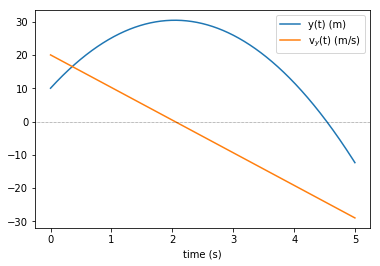

In [9]:
g = 9.8 # gravitational acceleration in m/s^2

tstart = 0.0
tend = 5.0 # solve for a period of 5 seconds.
N = 1000 # number of points for Runge-Kutta
h = (tend - tstart)/N 

tpoints = np.arange(tstart, tend, h)

# define the initial conditions
initialy = 10 # initial y position, in metres
intialvy = 20 # initial y-velocity in m/s. Positive, so it's thrown upwards
r = np.array([initialy, intialvy])

rsol = RungeKutta2d(r,tpoints) # this will be an array of the x and y solutions

plt.plot(tpoints,rsol[0],label="y(t) (m)")
plt.plot(tpoints,rsol[1],label="v$_y$(t) (m/s)")
plt.legend()
plt.axhline(c="k",ls=":", lw=0.5) # draw black dotted line at y (or v_y) = 0
plt.xlabel("time (s)")


As we'd expect, the particle rises to its maximum height and then falls, while the velocity decreases linearly, passing through zero at the highest point of the trajectory. It all works!

## Your task: A non-linear pendulum

At some point you've almost certainly solved the problem of a pendulum by using the approximation of a linear differential equation that can be solved analytically.

A real pendulum, however, is non-linear, and can't be solved for analytically. Let's look at this more closely:





In [10]:
from IPython.display import Image # needed to embed an image
Image(filename='Pendulum.png', embed=True)

FileNotFoundError: [Errno 2] No such file or directory: 'Pendulum.png'

The image above (download/view it from Moodle if it doesn't show up) shows a pendulum of length $L$ with a bob of mass $M$. We assume that all the mass of the system is in the bob, and that the system is rigid.

The pendulum experiences a torque
$$
  \tau_p = MgL \sin(\theta),
$$

and we also know that the torque of a rigid body is  given by

$$
  \tau = I \alpha,
$$

where $I$ is the moment of inertia and $\alpha$ the angular
acceleration. These are given by

$$
  I = ML^2 \qquad \text{and} \qquad  \alpha = \frac{d\omega}{dt} = \frac{d^2\theta}{dt^2},
$$

where $\omega$ is the angular velocity.
We can then rewrite the equation for the torque in terms of the
angular position of the pendulum (note that a minus sign appears because the torque and the angle are measured in opposite directions):

$$
  \tau_p = - I \frac{d^2\theta}{dt^2}.
$$

Substituting and rearranging gives us the equation of motion for
the pendulum:

$$
  \frac{d^2\theta}{dt^2} = - \frac{MgL}{I} \sin(\theta) = - \frac{g}{L}
  \sin(\theta),
$$
 which tells us that the bob accelerates towards the rest point at $\theta = 0$, and that the acceleration is dependent on the sine of the angle of displacement.

Now, if we were solving this analytically, we'd be stuck - there's no exact analytical solution to this. We'd need to make an approximation in order to continue. The obvious one here is to use the small angle approximation, and put $\sin(\theta) \approx \theta$, which (as the name suggests) is only valid when $\theta$ is small. This transforms the problem into a linear ODE, which is simple to solve analytically.

But by using our numerical methods, we can solve this system for big angles. We can separate out into two first-order equations, as before, where the two variables are now the angle $\theta$ (c.f. position $y$) and the angular velocity $\omega$ (c.f. y-velocity)

$$ \frac{d \theta}{d t} = \omega$$

$$ \frac{d \omega}{dt} = -\frac{g}{L}\sin\theta $$

### <div class="alert alert-success"> For this task, start a new notebook from scratch. <br> <br> Remember to use text cells to describe your reasoning and results, and comments to annotate the code. Aim for a completely self-contained notebook.<br> <br>You can cut and paste code, equations and images from this notebook if you want. </div>

### Task instructions:

2. Set up a python function, analogous to our function f(r,t) above, to calculate $\frac{d \theta}{d t}$  and $\frac{d \omega}{dt}$.

3. Use the Runge-Kutta routine (cut and paste the function if you want) to solve for a pendulum with $L =$ 1 m released at $t = 0$ from rest with an initial angle (in radians) of $\theta = 0.99 \pi$ for a duration of 20 seconds (this angle is nearly vertical - about as far from a small angle as possible!) . 

4. Plot the angle $\theta$ and the angular velocity $\omega$ on an appropriately labelled plot. In a text cell, compare these results with the results you'd obtain when we use the $\sin \theta \approx \theta$ approximation *(n.b you don't have to calculate the $\sin \theta \approx \theta$ results, although you are welcome to if you have time (not for credit))*.

5. Now try these:
      1. To make our pendulum even more realistic, we can also include a damping term. For this we need to define a damping coefficient $c$ (start with $c=0.01$), and to take into account the mass of the bob (use $M = 0.1$ kg). The expression for the angular acceleration then becomes
$$
\frac{d \omega}{dt}  = -\frac{g}{L}\sin(\theta)  - \frac{c \omega}{M L^2}
$$
Write a new function to calculate for the damped motion of the pendulum, and plot these results in addition to the undamped results.
      2. Create a vpython animation of the pendulum using the array of solutions to the ODEs that you used for the plots. The following two code cells contain suggested forms for the visual objects and the animation loop. Remember that you'll need to import these vpython commands from the "visual" module. You can choose to visualise either the damped or undamped version, or even both. 
      *Note: running vpython within an IPython Notebook can result in a "not responding" vpython error after the animation finishes running. If this happens to you, just close the vpython window and restart the kernel. (This is likely to be fixed in future versions!)*
      
      

In [11]:
pivot = np.array([0,0,0]) # pivot point at centre of display
# the rigid rod connecting the bob to the pivot point...
rod = cylinder(pos=pivot, axis = (L*np.sin(initialtheta),-L*np.cos(initialtheta),0), 
                      radius = 0.01, color=color.red)
# ...and the bob.
bob = sphere(pos=(L*np.sin(initialtheta),-L*np.cos(initialtheta),0), 
                      radius = 0.1, color=color.blue)

NameError: name 'cylinder' is not defined

In [12]:
# Loop over the solution already calculated
i = 0 # frame counter
while i < N:
    angle = rsol[0,i] 
    # change the axis of the bob
    rod.axis = (L*np.sin(angle), -L*np.cos(angle),0)
    #update the position of the bob:
    bob.pos = (L*np.sin(angle),-L*np.cos(angle),0)
    i += 1 # increment frame
    rate(50) # framerate

NameError: name 'L' is not defined